In [96]:
import os
from google.cloud import bigquery
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [48]:
PROJECT_ID = "integrated-bit-312717"
DATASET_NAME = 'customs'
TABLE_NAME = "customs_test3"

table_id = "{project_id}.{dataset_name}.{table_name}".format(project_id=PROJECT_ID, dataset_name=DATASET_NAME, 
            table_name=TABLE_NAME)
table_id

'integrated-bit-312717.customs.customs_test3'

In [49]:
client = bigquery.Client(project=PROJECT_ID, location="US")

In [50]:
query_job = client.query(
    """
        SELECT DISTINCT `year_month` from `{table_id}` 
    """.format(table_id=table_id)
)
result = query_job.result()
print(result)
year_month = [row.year_month for row in result]
year_month.sort()
year_month

['2001-01',
 '2001-02',
 '2001-03',
 '2001-04',
 '2001-05',
 '2001-06',
 '2001-07',
 '2001-08',
 '2001-09',
 '2001-10',
 '2001-11',
 '2001-12',
 '2002-01',
 '2002-02',
 '2002-03',
 '2002-04',
 '2002-05',
 '2002-06',
 '2002-07',
 '2002-08',
 '2002-09',
 '2002-10',
 '2002-11',
 '2002-12',
 '2003-01',
 '2003-02',
 '2003-03',
 '2003-04',
 '2003-05',
 '2003-06',
 '2003-07',
 '2003-08',
 '2003-09',
 '2003-10',
 '2003-11',
 '2003-12',
 '2004-01',
 '2004-02',
 '2004-03',
 '2004-04',
 '2004-05',
 '2004-06',
 '2004-07',
 '2004-08',
 '2004-09',
 '2004-10',
 '2004-11',
 '2004-12',
 '2005-01',
 '2005-02',
 '2005-03',
 '2005-04',
 '2005-05',
 '2005-06',
 '2005-07',
 '2005-08',
 '2005-09',
 '2005-10',
 '2005-11',
 '2005-12',
 '2006-01',
 '2006-02',
 '2006-03',
 '2006-04',
 '2006-05',
 '2006-06',
 '2006-07',
 '2006-08',
 '2006-09',
 '2006-10',
 '2006-11',
 '2006-12',
 '2007-01',
 '2007-02',
 '2007-03',
 '2007-04',
 '2007-05',
 '2007-06',
 '2007-07',
 '2007-08',
 '2007-09',
 '2007-10',
 '2007-11',
 '20

In [61]:
query_job = client.query(
    """
        SELECT DISTINCT `country` from `{table_id}` 
    """.format(table_id=table_id)
)
result = query_job.result()
print(result)
countrys = [row.country for row in result]
countrys.sort()
countrys

['&Aring;LAND ISLANDS',
 'AFGHANISTAN',
 'ALBANIA',
 'ALGERIA',
 'AMERICAN SAMOA',
 'ANDORRA',
 'ANGOLA',
 'ANGUILLA',
 'ANTARCTICA',
 'ANTIGUA AND BARBUDA',
 'ARGENTINA',
 'ARMENIA',
 'ARUBA',
 'AUSTRALIA',
 'AUSTRIA',
 'AZERBAIJAN',
 'BAHAMAS',
 'BAHRAIN',
 'BANGLADESH',
 'BARBADOS',
 'BELARUS',
 'BELGIUM',
 'BELIZE',
 'BENIN',
 'BERMUDA',
 'BHUTAN',
 'BOLIVIA',
 'BONAIRE,SAINT EUSTATIUS AND SABA',
 'BOSNIA AND HERZEGOVINA    ',
 'BOTSWANA',
 'BOUVET ISLAND',
 'BRAZIL',
 'BRITISH INDIAN OCEAN TERRITORY',
 'BRUNEI DARUSSALAM',
 'BULGARIA',
 'BURKINA FASO',
 'BURUNDI',
 'CAMBODIA',
 'CAMEROON',
 'CANADA',
 'CAPE VERDE',
 'CAYMAN ISLANDS',
 'CENTRAL AFRICAN REPUBLIC',
 'CHAD',
 'CHILE',
 'CHINA',
 'CHRISTMAS ISLAND',
 'COCOS (KEELING) ISLANDS',
 'COLOMBIA',
 'COMOROS',
 'CONGO',
 'CONGO, THE DEMOCRATIC REPUBLIC OF T',
 'COOK ISLANDS',
 'COSTA RICA',
 'COTE D IVOIRE',
 'CROATIA',
 'CUBA',
 'CURACAO',
 'CYPRUS',
 'CZECH REPUBLIC',
 'DDD',
 'DENMARK',
 'DJIBOUTI',
 'DOMINICA',
 'DOMINICAN 

In [102]:
class BatchData:
    
    def __init__(self, year_months, countrys):
        self.year_months = year_months
        self.year_months_index = 0
        self.types = ['import', 'export']
        self.countrys = countrys
        self.n_year_month = len(year_months)
        
    def query_from_bq(self, year_month):
        query_job = client.query(
            """
                SELECT * from `{table_id}` WHERE `year_month`='{year_month}'
            """.format(table_id=table_id, year_month=year_month)
        )
        result = query_job.result()
        return [
                    {
                        'country':row.country,
                        'hs_code':row.hs_code,
                        'type':row.type,
                        'year_month':row.year_month,
                        'value':row.value
                    } for row in result
        ]
    
    def get_data(self, year_month):
        data = self.query_from_bq(year_month)
        df = pd.DataFrame(data)
        df['country']=df['country'].apply(lambda x: self.countrys.index(x))
        df['type']=df['type'].apply(lambda x: self.types.index(x))
        df['year']=df['year_month'].apply(lambda x: int(x.split('-')[0]))
        df['month']=df['year_month'].apply(lambda x: int(x.split('-')[1]))
        df = df.drop(['year_month'], axis=1)
        X = df.drop(['value'], axis=1).to_numpy()
        y = df['value'].to_numpy()
        X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=True)
        return X_train, y_train, X_test, y_test
    
    def get_batch_data(self):
        year_month = self.year_months[self.year_months_index]
        print("Get data {}".format(year_month))
        return self.get_data(year_month)
    
    def next_batch(self):
        self.year_months_index += 1
    
    

In [103]:
batch_data = BatchData(year_month, countrys)

In [104]:
example_data = batch_data.get_batch_data()
example_data

Get data 2001-01


(array([[241, '3212', 0, 2001, 2001],
        [102, '8431', 0, 2001, 2001],
        [50, '4202', 1, 2001, 2001],
        ...,
        [114, '4304', 1, 2001, 2001],
        [205, '2520', 1, 2001, 2001],
        [44, '6107', 1, 2001, 2001]], dtype=object),
 array([2707199,  155143,  198447, ...,   44907, 1918507,       0]),
 array([[136, '9503', 1, 2001, 2001],
        [241, '4823', 0, 2001, 2001],
        [137, '8406', 1, 2001, 2001],
        ...,
        [221, '4907', 0, 2001, 2001],
        [214, '8423', 0, 2001, 2001],
        [238, '3701', 0, 2001, 2001]], dtype=object),
 array([       0, 26720513,        0, ...,     4929,        0,        0]))

In [105]:
from sklearn.linear_model import SGDRegressor, PassiveAggressiveRegressor

# Fit SGDRegressor

In [106]:
sgd_regressor = SGDRegressor()

In [107]:
scores = []
pbar = tqdm(range(batch_data.n_year_month))
for index in pbar:
    X_train, y_train, X_test, y_test = batch_data.get_batch_data()
    sgd_regressor.partial_fit(X_train, y_train)
    score = sgd_regressor.score(X_test, y_test)
    scores.append(score)
    pbar.set_postfix({'score':score})
    batch_data.next_batch()

  0%|          | 0/252 [00:00<?, ?it/s]

Get data 2001-01
Get data 2001-02
Get data 2001-03
Get data 2001-04
Get data 2001-05
Get data 2001-06
Get data 2001-07
Get data 2001-08
Get data 2001-09
Get data 2001-10
Get data 2001-11
Get data 2001-12
Get data 2002-01
Get data 2002-02
Get data 2002-03
Get data 2002-04
Get data 2002-05
Get data 2002-06
Get data 2002-07
Get data 2002-08
Get data 2002-09
Get data 2002-10
Get data 2002-11
Get data 2002-12
Get data 2003-01
Get data 2003-02
Get data 2003-03
Get data 2003-04
Get data 2003-05
Get data 2003-06
Get data 2003-07
Get data 2003-08
Get data 2003-09
Get data 2003-10
Get data 2003-11
Get data 2003-12
Get data 2004-01
Get data 2004-02
Get data 2004-03
Get data 2004-04
Get data 2004-05
Get data 2004-06
Get data 2004-07
Get data 2004-08
Get data 2004-09
Get data 2004-10
Get data 2004-11
Get data 2004-12
Get data 2005-01
Get data 2005-02
Get data 2005-03
Get data 2005-04
Get data 2005-05
Get data 2005-06
Get data 2005-07
Get data 2005-08
Get data 2005-09
Get data 2005-10
Get data 2005-

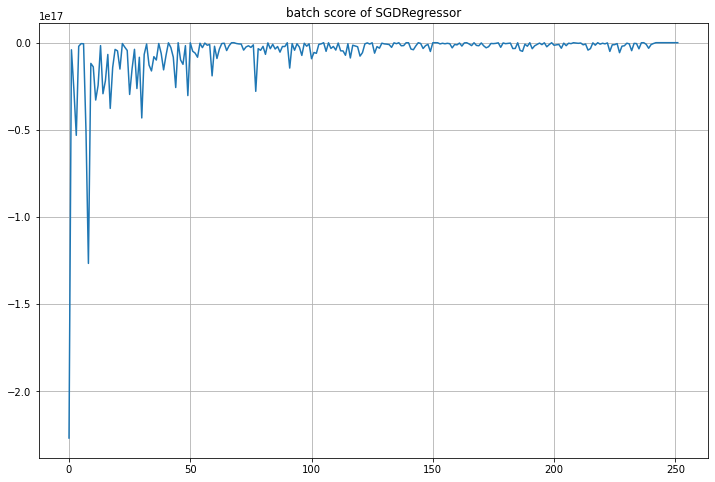

In [108]:
plt.figure(figsize=(12,8))
plt.title("batch score of SGDRegressor")
plt.plot(scores)
plt.grid()

# Fit PassiveAggressiveRegressor

In [111]:
batch_data = BatchData(year_month, countrys)

In [112]:
passive_aggressive_regressor = PassiveAggressiveRegressor()

In [113]:
scores = []
pbar = tqdm(range(batch_data.n_year_month))
for index in pbar:
    X_train, y_train, X_test, y_test = batch_data.get_batch_data()
    passive_aggressive_regressor.partial_fit(X_train, y_train)
    score = passive_aggressive_regressor.score(X_test, y_test)
    scores.append(score)
    pbar.set_postfix({'score':score})
    batch_data.next_batch()

  0%|          | 0/252 [00:00<?, ?it/s]

Get data 2001-01
Get data 2001-02
Get data 2001-03
Get data 2001-04
Get data 2001-05
Get data 2001-06
Get data 2001-07
Get data 2001-08
Get data 2001-09
Get data 2001-10
Get data 2001-11
Get data 2001-12
Get data 2002-01
Get data 2002-02
Get data 2002-03
Get data 2002-04
Get data 2002-05
Get data 2002-06
Get data 2002-07
Get data 2002-08
Get data 2002-09
Get data 2002-10
Get data 2002-11
Get data 2002-12
Get data 2003-01
Get data 2003-02
Get data 2003-03
Get data 2003-04
Get data 2003-05
Get data 2003-06
Get data 2003-07
Get data 2003-08
Get data 2003-09
Get data 2003-10
Get data 2003-11
Get data 2003-12
Get data 2004-01
Get data 2004-02
Get data 2004-03
Get data 2004-04
Get data 2004-05
Get data 2004-06
Get data 2004-07
Get data 2004-08
Get data 2004-09
Get data 2004-10
Get data 2004-11
Get data 2004-12
Get data 2005-01
Get data 2005-02
Get data 2005-03
Get data 2005-04
Get data 2005-05
Get data 2005-06
Get data 2005-07
Get data 2005-08
Get data 2005-09
Get data 2005-10
Get data 2005-

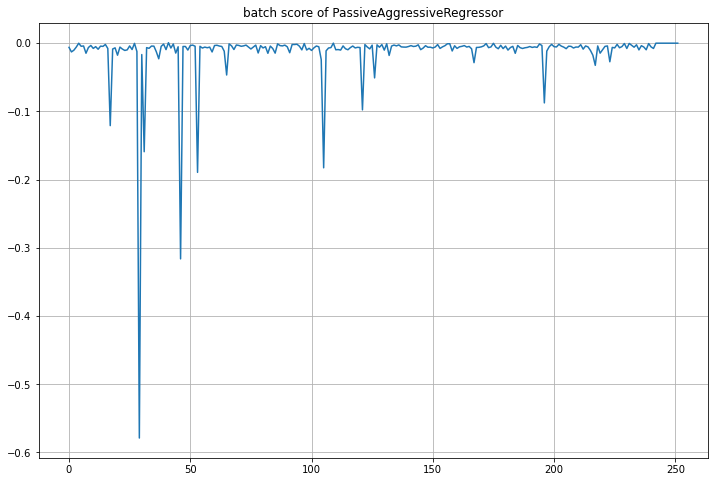

In [114]:
plt.figure(figsize=(12,8))
plt.title("batch score of PassiveAggressiveRegressor")
plt.plot(scores)
plt.grid()

# Save model

In [115]:
import pickle

In [116]:
base_dir = 'bucket/models'
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

In [117]:
# save sgd_regressor model
model_name = 'sgd_regressor.sk'
model_path = os.path.join(base_dir, model_name)
with open(model_path, 'wb') as f:
    pickle.dump(sgd_regressor,f)

In [118]:
# save passive_aggressive_regressor model
model_name = 'passive_aggressive_regressor.sk'
model_path = os.path.join(base_dir, model_name)
with open(model_path, 'wb') as f:
    pickle.dump(passive_aggressive_regressor,f)